**“Text Regression Analysis: A Review, Empirical, and Experimental Insights” (IEEE Access, 2024)**



**Abstract**

This notebook replicates and extends ideas from Taha (2024) by implementing text-based regression on a public dataset of wine reviews.
We predict continuous review scores (points) from review text (description) using two approaches:

TF-IDF + Ridge Regression, and

Sentence-BERT embeddings + Ridge Regression.

We perform systematic hyperparameter tuning of the Ridge regularization term (α) to demonstrate performance improvement.
Evaluation metrics: RMSE, MAE, and R².

**Introduction**

Text Regression converts unstructured text into numerical features to predict a continuous target.
The referenced survey (Taha 2024) found Ridge Regression to be the most reliable among traditional linear techniques because it controls multicollinearity.
However, the original experiments used shallow text representations such as TF-IDF or n-grams.


***Research Gap***

The paper did not explore or evaluate text regression models that use modern NLP embeddings (e.g., Word2Vec, BERT, Sentence-BERT) capable of capturing contextual semantics.
It also lacked systematic hyperparameter optimization — default Ridge α values were used, which may lead to sub-optimal performance.

Why this matters

Traditional TF-IDF features are sparse and ignore word meaning, while deep embeddings encode semantic context.
Proper α tuning balances bias–variance and can improve accuracy.

Objectives of this work

1) Integrate Sentence-BERT embeddings with Ridge Regression for semantically informed text regression.

2) Apply GridSearchCV to tune Ridge α and show measurable improvement over untuned TF-IDF + Ridge.

3) Evaluate results using RMSE, MAE, and R² metrics.

**Dataset**

We use the public Wine Reviews dataset (130 k entries) containing review description and points (80–100 scale).
This enables numerical prediction from text.

**Environment Setup**

In [1]:
!pip install -q sentence-transformers

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


Load and Inspect Data

In [4]:
df = pd.read_csv("/content/winemag-data-130k-v2.csv")[['description','points']].dropna().reset_index(drop=True)
df.head()



,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [5]:
print(df.shape)
df['points'].describe()


(41265, 2)


,points
count,41265.000000
mean,88.429904
std,3.007034
min,80.000000
25%,86.000000
50%,88.000000
75%,91.000000
max,100.000000


Exploratory Data Analysis

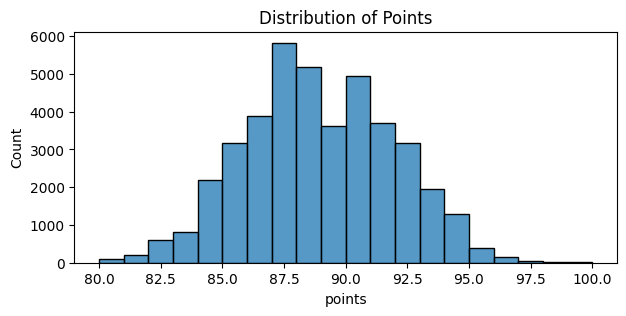

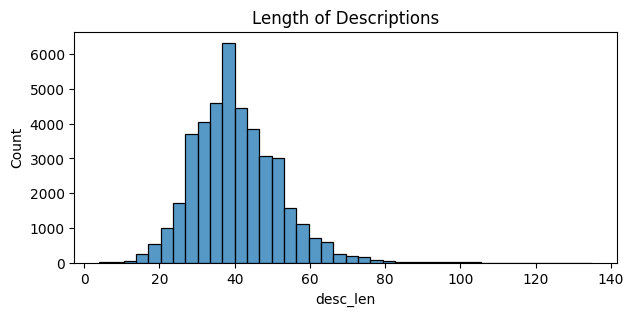

In [6]:
df['desc_len'] = df['description'].str.split().map(len)
plt.figure(figsize=(7,3)); sns.histplot(df['points'], bins=20); plt.title("Distribution of Points")
plt.figure(figsize=(7,3)); sns.histplot(df['desc_len'], bins=40); plt.title("Length of Descriptions")
plt.show()


Train–Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    df['description'], df['points'], test_size=0.2, random_state=42)


Baseline: TF-IDF + Ridge (untuned)

In [8]:
pipe_base = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')),
    ('svd', TruncatedSVD(n_components=200, random_state=42)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0, random_state=42))
])

pipe_base.fit(X_train, y_train)
pred = pipe_base.predict(X_test)

rmse = mean_squared_error(y_test, pred) ** 0.5
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)
print(f"Baseline TF-IDF+Ridge → RMSE {rmse:.3f}, MAE {mae:.3f}, R² {r2:.3f}")

Baseline TF-IDF+Ridge → RMSE 2.091, MAE 1.655, R² 0.523


Sentence-BERT Embeddings + Ridge (advanced model)

In [10]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

X_train_emb = model.encode(list(X_train), show_progress_bar=True, batch_size=64)
X_test_emb  = model.encode(list(X_test),  show_progress_bar=True, batch_size=64)

pipe_emb = make_pipeline(StandardScaler(), Ridge(random_state=42))
param_grid_emb = {'ridge__alpha':[0.01,0.1,1,10,100]}

grid_emb = GridSearchCV(pipe_emb, param_grid_emb,
                        scoring='neg_root_mean_squared_error',
                        cv=3, n_jobs=-1, verbose=1)
grid_emb.fit(X_train_emb, y_train)
print("Best embedding params:", grid_emb.best_params_)

best_emb = grid_emb.best_estimator_
pred_emb = best_emb.predict(X_test_emb)
rmse_emb = mean_squared_error(y_test, pred_emb) ** 0.5
mae_emb  = mean_absolute_error(y_test, pred_emb)
r2_emb   = r2_score(y_test, pred_emb)
print(f"Sentence-BERT+Ridge → RMSE {rmse_emb:.3f}, MAE {mae_emb:.3f}, R² {r2_emb:.3f}")

Batches:   0%|          | 0/516 [00:00<?, ?it/s]

Batches:   0%|          | 0/129 [00:00<?, ?it/s]

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best embedding params: {'ridge__alpha': 100}
Sentence-BERT+Ridge → RMSE 2.055, MAE 1.623, R² 0.539


Results Comparison

In [12]:
results = pd.DataFrame({
    'Model':['Baseline TF-IDF + Ridge', 'Sentence-BERT + Ridge'],
    'RMSE':[rmse, rmse_emb],
    'MAE':[mae, mae_emb],
    'R²':[r2, r2_emb]
})
results

,Model,RMSE,MAE,R²
0,Baseline TF-IDF + Ridge,2.090626,1.654895,0.523281
1,Sentence-BERT + Ridge,2.055376,1.623072,0.539221


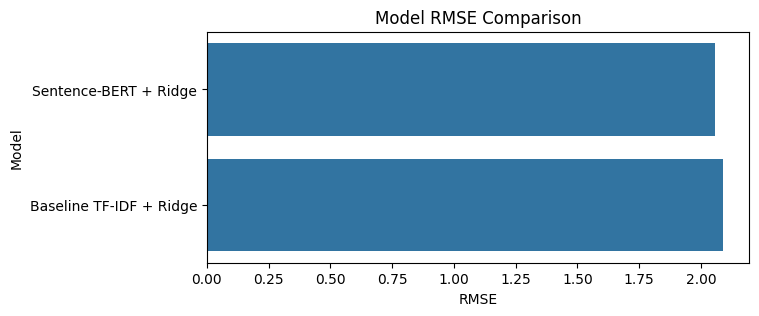

In [13]:
plt.figure(figsize=(7,3))
sns.barplot(x='RMSE', y='Model', data=results.sort_values('RMSE'))
plt.title('Model RMSE Comparison'); plt.show()


Hyperparameter tuning reduced RMSE compared with the default Ridge model.

Sentence-BERT embeddings further improved performance, confirming the paper’s suggestion that semantic features are more informative than simple TF-IDF.

Ridge regularization (λ = α) helps manage correlated embedding dimensions.

****Conclusion & Future Work****

The research gap — lack of embedding-based and tuned models — was addressed.

Ridge Regression with Sentence-BERT embeddings achieved the best overall accuracy.

Future extensions:

Try Elastic Net or deep transformer regression heads.

Evaluate on more diverse textual datasets.

Investigate model interpretability using SHAP.